## **Plant pathology classification**

The project concerns the recognition of apple leaf diseases based on their photos. The leaves are classified as "healthy", "multiple diseases", "scab" and "rust". This is a multiclass classification problem.

**Data**

The data comes from kaggle competition (Plant Pathology 2020 - FGVC7).

#### **Import libraries and data**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

tf.__version__

'2.5.0'

Read data:

In [ ]:
images_path = '/content/drive/My Drive/moje pliki/plant/images'
train = pd.read_csv('/content/drive/My Drive/moje pliki/plant/train.csv')
test = pd.read_csv('/content/drive/My Drive/moje pliki/plant/train.csv')

### **Data analysis**

The dataset contains csv. files divided into training and test ones and a folder of photos in jpg format. 

The data include photos of the apple leaves describing their diseases. There are 4 classes: healthy, rust, scub and multiple diseases.

In [ ]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
train.shape

(1821, 5)

In [ ]:
test.shape

(1821, 5)

Number of photos in each class: 

In [ ]:
number_of_images = ['healthy', 'multiple_diseases', 'rust', 'scab']

print(train[number_of_images].sum())

healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


After first observations we can see that we have 1,821 images with 4 classes in the training data and the same amount of test data. 

#### **Data visualization**

Distribution of individual classes on the charts: 

Text(0, 0.5, 'Counts')

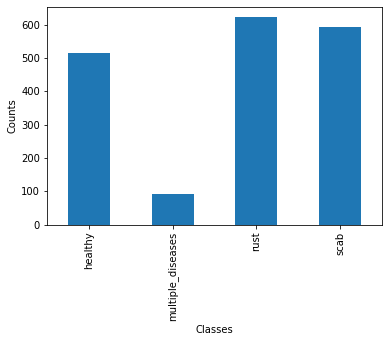

In [ ]:
train[number_of_images].sum().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Counts')

Distribution of data for individual variables: 

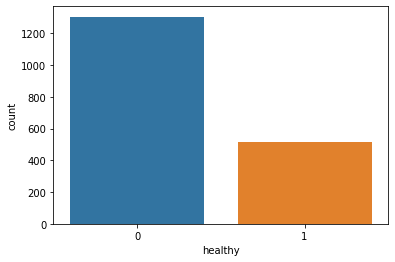

In [ ]:
sns.countplot(train['healthy']);

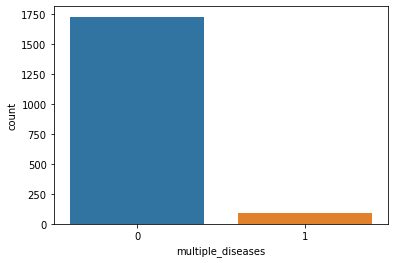

In [ ]:
sns.countplot(train['multiple_diseases']);

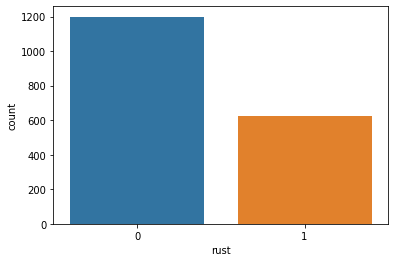

In [ ]:
sns.countplot(train['rust']);

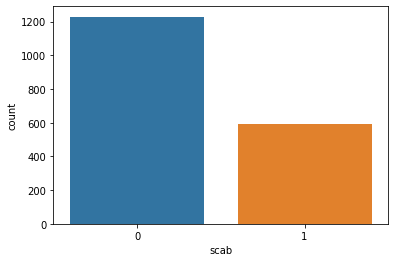

In [ ]:
sns.countplot(train['scab']);

After analyzing the dataset we can see that the data is out of balance. The fewest images are in the category of multiple diseases. 

### **Data preparation**

We divide the data into training and test sets and change the image size to 224 (the images are too large, so we reduce them to be able to load them into the model). 

In [ ]:
img_size = 224

train_images = []

for name in train['image_id']:
  path = os.path.join(images_path, name) + ".jpg"
  image = cv2.imread(path)
  img = cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
  train_images.append(img)


In [ ]:
test_images = []

for name in test['image_id']:
  path = os.path.join(images_path, name) + ".jpg"
  image = cv2.imread(path)
  img = cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
  test_images.append(img)

In [ ]:
len(train_images), len(test_images)

(1821, 1821)

Visualization of images: 

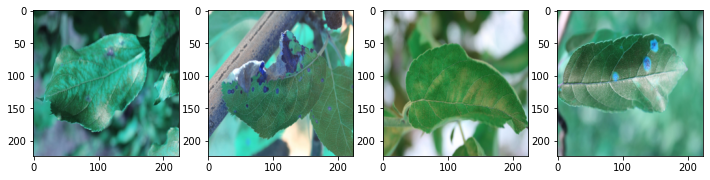

In [ ]:
#train set
f, ax = plt.subplots(1, 4, figsize=(12,12))
for i in range(4):
  ax[i].imshow(train_images[i])




Then we need to write the data to array and rescale all the images. The RGB channel values need to be standardized, which are in the range of [0, 255], so that they are in the range of [0, 1]. 

Train set:

In [ ]:
X_train = np.ndarray(shape=(len(train_images), img_size, img_size, 3), dtype = np.float32)

for i, img in enumerate(train_images):
  X_train[i] = img_to_array(img)
  X_train[i] = train_images[i]

X_train = X_train/255

print(X_train.shape)

(1821, 224, 224, 3)


In [ ]:
y_train = train.drop(columns=['image_id'])
y_train = np.array(y_train.values)

In [ ]:
y_train

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
y_train.shape

(1821, 4)

The same transformation for test set: 

In [ ]:
X_test = np.ndarray(shape=(len(test_images), img_size, img_size, 3), dtype = np.float32)

for i, img in enumerate(test_images):
  X_test[i] = img_to_array(img)
  X_test[i] = test_images[i]

X_test = X_test/255

print(X_test.shape)

(1821, 224, 224, 3)


In [ ]:
y_test = test.drop(columns=['image_id'])
y_test = np.array(y_test.values)

**Division of data into train, test and validation data**

We divide the data into a training and validation sets by use `train_test_split` method in sklearn library. We split them into 80% of training data and 20% of validation data. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train ,y_train ,test_size=0.2,random_state=42)

X_train.shape, X_val.shape

((1456, 224, 224, 3), (365, 224, 224, 3))

Since the dataset is not balanced we have to create a balanced dataset for each class. The results give the same number of samples in multiple classes. 


To get a balanced data set we will use the SMOTE library: 

In [ ]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train.reshape((-1, img_size*img_size*3)), y_train)

X_train = X_train.reshape((-1, img_size, img_size, 3))

In [ ]:
X_train.shape, y_train.shape

((2008, 224, 224, 3), (2008, 4))

In [ ]:
y_train.sum(axis=0)

array([502, 502, 502, 502])

### **Creating the model**

We build model with Convolutional Neural Network (CNN) and we will test a few models.

The model 1 consists of four convolution blocks with a max pool layer in each of them (CNN+pooling). After second layer CNN we increase number of filters *2. Next there's a fully connected layer with three Dense layers. First two layers are activated by a relu activation function and the last one is activated by a softmax activation function.

In [ ]:
model = Sequential([                
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)), 
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=32, activation="relu"),
  tf.keras.layers.Dense(units=4, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)      

**Compile the model:**

We choose the `Adam` optimizer and the loss function: `categorical_crossentropy`. To view training and validation accuracy for each training epoch, we use metrics "accuracy".


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

**Train the model**

We train the model for 30 epoch.


In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size = 32,
    epochs = 30,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
63/63 [==============================] - 8s 100ms/step - loss: 1.3876 - accuracy: 0.2495 - val_loss: 1.3514 - val_accuracy: 0.2740
Epoch 2/30
63/63 [==============================] - 5s 82ms/step - loss: 1.3325 - accuracy: 0.3601 - val_loss: 1.2604 - val_accuracy: 0.4301
Epoch 3/30
63/63 [==============================] - 5s 82ms/step - loss: 1.2306 - accuracy: 0.4831 - val_loss: 1.2274 - val_accuracy: 0.3973
Epoch 4/30
63/63 [==============================] - 5s 83ms/step - loss: 1.0489 - accuracy: 0.5697 - val_loss: 1.0472 - val_accuracy: 0.5534
Epoch 5/30
63/63 [==============================] - 6s 89ms/step - loss: 0.8142 - accuracy: 0.6713 - val_loss: 0.8331 - val_accuracy: 0.6630
Epoch 6/30
63/63 [==============================] - 5s 83ms/step - loss: 0.5619 - accuracy: 0.7644 - val_loss: 0.8696 - val_accuracy: 0.6986
Epoch 7/30
63/63 [==============================] - 5s 83ms/step - loss: 0.4123 - accuracy: 0.8272 - val_loss: 1.0550 - val_accuracy: 0.6658
Epoch 8/30
6

**Visualization training results**

The plots of loss and accuracy on the training and validation sets.


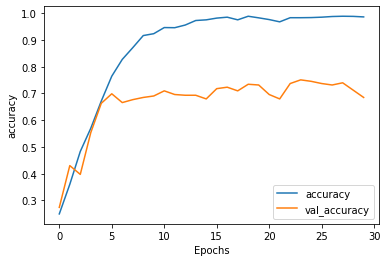

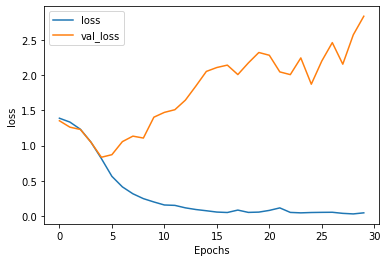

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Prediction on test set:**

In [ ]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9915
Testing Accuracy:  0.9281


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing loss:  {:.4f}".format(loss))

Testing loss:  0.6008


In [ ]:
pred = model.predict(X_test)
pred

array([[1.7609575e-01, 1.6137984e-01, 8.6026460e-02, 5.7649791e-01],
       [1.8976671e-05, 4.1742873e-01, 5.8103406e-01, 1.5182424e-03],
       [6.7399293e-01, 7.7951662e-02, 1.5474795e-02, 2.3258060e-01],
       ...,
       [3.0585459e-01, 9.8921999e-02, 3.9662220e-02, 5.5556124e-01],
       [1.3920330e-02, 2.2138312e-01, 7.4003583e-01, 2.4660721e-02],
       [4.0325168e-01, 4.9821440e-02, 3.8063101e-02, 5.0886381e-01]],
      dtype=float32)

Confusion matrix:

In [ ]:
data_count, w, h, c = X_test.shape

X_test_array=np.reshape(X_test, (data_count, w, h, c))
y_test_array = np.reshape(y_test , (data_count, -1))

In [ ]:
cm = confusion_matrix(y_test_array.argmax(axis=1), pred.argmax(axis=1))
cm

array([[435,   1,   0,  80],
       [ 23,  32,  17,  19],
       [ 22,  57, 533,  10],
       [174,  31,   1, 386]])

Prediction for 10 first variables:

In [ ]:
result = pd.DataFrame()
result['image_id'] = test['image_id']
result['healthy'] = pred[:, 0]
result['multiple_diseases'] = pred[:, 1]
result['rust'] = pred[:, 2]
result['scab'] = pred[:, 3]
result.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0.176096,0.161380,0.086026,0.576498
1,Train_1,0.000019,0.417429,0.581034,0.001518
2,Train_2,0.673993,0.077952,0.015475,0.232581
3,Train_3,0.000096,0.279564,0.718865,0.001474
4,Train_4,0.679363,0.078793,0.020858,0.220986
5,Train_5,0.358251,0.188824,0.056882,0.396043
6,Train_6,0.080583,0.402907,0.072693,0.443817
7,Train_7,0.148342,0.128189,0.052999,0.670471
8,Train_8,0.251770,0.045549,0.035743,0.666938
9,Train_9,0.233204,0.126789,0.044168,0.595839


In [ ]:
#save the model
model.save("plant_model.h5")

**Conclusion for model 1:**


Looking at the loss and accuracy training graphs we can see that after 5 epoch there is a noticeable difference in accuracy between the training and validation sets. So we are dealing with overfitting. The loss decreases similarly on both sets, and then after the 5 epoch it starts to increase on the validation set. However, after checking the metrics on the test set we obtained 93% accuracy, close to the training set. After checking the confusion matrix, it can be seen that many samples were classified incorrectly. This we can also see in the 'result' variable, where they are prediction results for the first 10 samples. 


### **Model 2 with data augumentation**

In the second model we will use data augmentation to check if the quality of the model can be improved. 

Data augmentation is a technique that allows us to add new data needed for the training process. It involves the use of various transformations of the available data to synthesize new images. 

To generate new data we will use the generator available in the Keras `ImageDataGenerator` library. The Image Data Generator has many options and also enables custom preprocessing functions. The images will supplemented with, among others, by displacement, rotation around its axis, horizontal and vertical flip. 



In [ ]:
#define generator
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip = True,
                             shear_range=0.1)

datagen_val = ImageDataGenerator()

In [ ]:
batch_size = 32

train_set = datagen.flow(X_train, y_train, batch_size=batch_size)

val_set = datagen_val.flow(X_val, y_val, batch_size=batch_size)

We will use the same network architecture as in the previous example. 

In [ ]:
model2 = Sequential([                
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)), 
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=32, activation="relu"),
  tf.keras.layers.Dense(units=4, activation="softmax")
])

In [ ]:
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

We are adding `Early Stopping` which allows learning to stop when the performance of the model stops improving in the validation dataset.  


In [ ]:
callback = EarlyStopping(monitor='val_loss', 
                         patience=3,
                         verbose=1)

We train the model for 30 epoch:

In [ ]:
history2 = model2.fit(train_set,
                    epochs = 30,
                    validation_data = val_set,
                    verbose=1,
                    callbacks=[callback])

Epoch 1/30
63/63 [==============================] - 26s 401ms/step - loss: 1.3894 - accuracy: 0.2480 - val_loss: 1.3685 - val_accuracy: 0.2740
Epoch 2/30
63/63 [==============================] - 25s 398ms/step - loss: 1.3726 - accuracy: 0.2963 - val_loss: 1.3859 - val_accuracy: 0.1425
Epoch 3/30
63/63 [==============================] - 25s 395ms/step - loss: 1.3543 - accuracy: 0.3202 - val_loss: 1.4315 - val_accuracy: 0.1425
Epoch 4/30
63/63 [==============================] - 25s 393ms/step - loss: 1.3358 - accuracy: 0.3431 - val_loss: 1.3006 - val_accuracy: 0.3397
Epoch 5/30
63/63 [==============================] - 24s 380ms/step - loss: 1.2920 - accuracy: 0.3720 - val_loss: 1.2383 - val_accuracy: 0.3342
Epoch 6/30
63/63 [==============================] - 24s 380ms/step - loss: 1.2276 - accuracy: 0.4208 - val_loss: 1.0987 - val_accuracy: 0.4575
Epoch 7/30
63/63 [==============================] - 25s 392ms/step - loss: 1.1944 - accuracy: 0.4437 - val_loss: 1.0162 - val_accuracy: 0.5671

The plots of loss and accuracy on the training and validation sets:

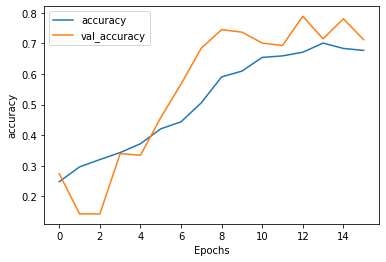

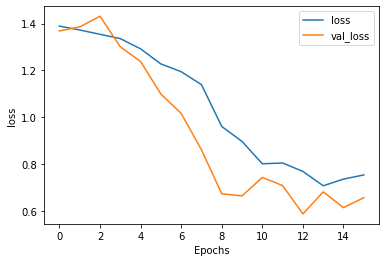

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

Prediction on test set:

In [ ]:
loss, accuracy = model2.evaluate(train_set, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test,y_test, verbose=False)
print("Testing loss:  {:.4f}".format(loss))

Training Accuracy: 0.7151
Testing Accuracy:  0.7408
Testing loss:  0.6216


**Conclusion for model 2:**

The model stopped after 16 epochs. From the graphs above, one can see that both training and validation loss are decreasing with a slight discrepancy compared to the result from the previous model. Likewise, the training and validation accuracy grow together. We see that overfitting is decreased. We also obtained a better accuracy on the test set - at the level of 74%, compared to the training set. 


**Model 3**

At the model 3 we have tested another model with augmentation. This time we have changed a bit the network architecture, adding two additional convolutional layers. 
Now the convolutional network consists of 3  double convolution blocks with a max pool layer in each of them (CNN+pooling).  After  second layer CNN we increase number of filters *2. Then a fully connected layer with three Dense layers. As before, the first two layers are activated by the relu activation function and the last one is activated by the softmax activation function.

In [ ]:
model3 = Sequential([                
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)), 
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=4, activation="softmax")
])

In [ ]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 56, 56, 128)      

In [ ]:
model3.compile(optimizer = Adam(learning_rate=0.0001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

We train the model for 50 epoch:

In [ ]:
history3 = model3.fit(train_set,
                    epochs = 50,
                    validation_data = val_set,
                    verbose=1,
                    callbacks=[callback])

Epoch 1/50
63/63 [==============================] - 34s 499ms/step - loss: 1.3814 - accuracy: 0.2460 - val_loss: 1.2930 - val_accuracy: 0.2740
Epoch 2/50
63/63 [==============================] - 29s 464ms/step - loss: 1.3329 - accuracy: 0.3606 - val_loss: 1.2457 - val_accuracy: 0.3562
Epoch 3/50
63/63 [==============================] - 29s 463ms/step - loss: 1.2460 - accuracy: 0.4328 - val_loss: 1.2299 - val_accuracy: 0.4466
Epoch 4/50
63/63 [==============================] - 30s 466ms/step - loss: 1.2299 - accuracy: 0.4363 - val_loss: 1.2377 - val_accuracy: 0.4356
Epoch 5/50
63/63 [==============================] - 29s 461ms/step - loss: 1.2186 - accuracy: 0.4482 - val_loss: 1.1703 - val_accuracy: 0.4822
Epoch 6/50
63/63 [==============================] - 29s 462ms/step - loss: 1.2072 - accuracy: 0.4542 - val_loss: 1.1445 - val_accuracy: 0.4986
Epoch 7/50
63/63 [==============================] - 29s 461ms/step - loss: 1.1508 - accuracy: 0.4950 - val_loss: 1.0820 - val_accuracy: 0.5342

The plots of loss and accuracy on the training and validation sets:

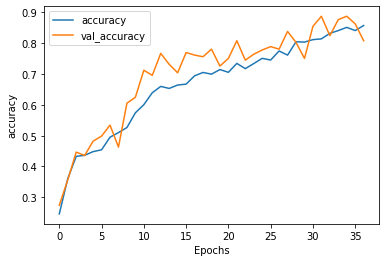

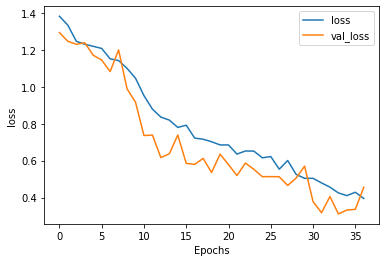

In [ ]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

**Prediction for model 3:**

In [ ]:
loss, accuracy = model3.evaluate(train_set, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test,y_test, verbose=False)
print("Testing loss:  {:.4f}".format(loss))

Training Accuracy: 0.8018
Testing Accuracy:  0.8490
Testing loss:  0.3744


In [ ]:
preds = model3.predict(X_test)

Confusion matrix:

In [ ]:
cm = confusion_matrix(y_test_array.argmax(axis=1), preds.argmax(axis=1))
cm

array([[506,   2,   4,   4],
       [ 12,  24,  53,   2],
       [  1,   1, 620,   0],
       [133,  56,   7, 396]])

In [ ]:
result = pd.DataFrame()
result['image_id'] = test['image_id']
result['healthy'] = preds[:, 0]
result['multiple_diseases'] = preds[:, 1]
result['rust'] = preds[:, 2]
result['scab'] = preds[:, 3]
result.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,1.323875e-01,0.062532,0.005002,8.000793e-01
1,Train_1,2.082792e-07,0.056583,0.943416,2.189168e-07
2,Train_2,9.641677e-01,0.007117,0.001471,2.724347e-02
3,Train_3,5.015939e-10,0.000537,0.999463,1.266143e-12
4,Train_4,8.852018e-01,0.060502,0.030164,2.413205e-02
5,Train_5,4.250301e-01,0.029379,0.003385,5.422056e-01
6,Train_6,2.104993e-02,0.714372,0.236680,2.789739e-02
7,Train_7,3.842438e-01,0.017687,0.000992,5.970770e-01
8,Train_8,3.132025e-01,0.029520,0.002033,6.552439e-01
9,Train_9,6.435619e-01,0.184642,0.080536,9.125953e-02


In [ ]:
#save the model
model3.save("plant_model_aug.h5")

**Conclusion for model 3**

The model stopped after 37 epochs. The training graphs show even smaller discrepancies between training and validation data compared to the result from Model 2. The loss of training and validation decreases comparably on both sets, and accuracy also increases . The accuracy of the test set was at the level of 85%  and was also better compared to the model 2. After checking the confusion matrix one can see that more samples were classified correctly compared to the model 1. This we can also see in the `result` variable, where they are prediction results for the first 10 samples. 



### **Summary**

From our analysis we can see that the model 3 is the best one. By virtue the data augmentation and by a little bit of architecture changes by adding two convolutional layers, it was possible to obtain a model with better accuracy. 
It is difficult to achieve good accuracy with a CNN model from scratch as overfitting can occur very frequently. We have to experiment with choosing the right architecture, test a few options. 

By checking the confusion matrix we can to determine in how many cases the model correctly or incorrectly classified the data. Therefore, in model 1 which despite that it had achieved quite a high accuracy on the test set, it was noticed that in many cases it had wrongly classified the samples.